In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
NUM_OF_DATA_FIELDS = 6
BINARY_FIELDS = []
TERNARY_FIELDS = [(1,2),(3,4,5)]

""" A function to create a grid graph that represents precincts in a state, divided into districts.

    Parameters
    ----------
    n_dist: int
        The number of districts to divide the state into

    x: int
        The number of rows the grid graph should have

    y: int
        The number of columns the grid graph should have (the total number of precincts will be x * y).

    Returns
    -------
    all_districts : networkx.Graph
        The graph representing the state
    
    actual_proportions : numpy.ndarray(dtype='float')
        The overall state data, generated based on the static constants defined above, where the value at index 0 is always 1
        (representing the overall population of the state) and the TERNARY_FIELDS list of tuples represents all the indices
        in each category of attributes that the population can be divided into (e.g. party, race, age, income level, etc.)
        
        As of 04/19/2022, TERNARY_FIELDS = [(1,2),(3,4,5)], meaning that the proportions at indices 1 and 2 represent one
        category (such as party - for example, index 1 being Democrat and index 2 being Republican -
        assuming all people in the state fall into one of the two categories),
        and the proportions at indices 3, 4 and 5 represent another (perhaps age or race).
    """
def make_grid_state(n_dist, x, y):
    graph = nx.grid_graph((x,y))
    n_prec = x * y
    precinct_numbers = assign_total_between_buckets(n_dist, n_prec)
    actual_proportions = generate_sensical_proportions()
    all_districts = generate_graph(graph, precinct_numbers, actual_proportions)
    return all_districts, actual_proportions

In [2]:
""" A function to divide some total quantity randomly between some number of buckets.

    Parameters
    ----------
    buckets: int
        The number of buckets to divide the total into

    total: int
        The number that the contents of the buckets should sum to

    Returns
    -------
    bucket_totals : list
        A list of randomized integer quantities with len(bucket_totals) == buckets and sum(bucket_totals) == total.
    
    """
def assign_total_between_buckets(buckets, total):
    bucket_totals = []
    for i in range(buckets):
        if i == buckets - 1:
            bucket_totals.append(total) #if we have reached the last bucket, put in the rest
        else:
            portion = np.random.randint(1, high = total - (buckets - i - 1)) #choose a random fraction
            bucket_totals.append(portion)
            total -= portion
    np.random.shuffle(bucket_totals)
    return bucket_totals

In [3]:
""" A function to generate proportions for state data based on the constants defined at the top of this file.

    Returns
    -------
    result : numpy.ndarray(dtype='float')
        The overall state data, generated based on the static constants defined above, where the value at index 0 is always 1
        (representing the overall population of the state) and the TERNARY_FIELDS list of tuples represents all the indices
        in each category of attributes that the population can be divided into (e.g. party, race, age, income level, etc.)
        
        NUM_OF_DATA_FIELDS represents the total number of attributes in the array. It is assumed that this is the sum of 
        the total number of elements in tuples in TERNARY_FIELDS, plus 1 for population, which is always placed at the 
        start of the array for convenience in later calculations.
        
        BINARY_FIELDS is currently unused, although much of the code in this file could be tweaked to make it usable;
        it represents indices in the array where there would be a category with a single field.
        
        As of 04/19/2022, TERNARY_FIELDS = [(1,2),(3,4,5)], meaning that the proportions at indices 1 and 2 represent one
        category (such as party - for example, index 1 being Democrat and index 2 being Republican -
        assuming all people in the state fall into one of the two categories),
        and the proportions at indices 3, 4 and 5 represent another (perhaps age or race).
    """
def generate_sensical_proportions():
    result = np.random.random(NUM_OF_DATA_FIELDS)
    result[0] = 1 #the proportion of people who live in the state to people who live in the state is simply 1
    for group_of_categories in TERNARY_FIELDS:
        #distribute the total population between the categories
        cat_proportions = assign_percent_between_buckets(len(group_of_categories), 1) 
        result[np.array(group_of_categories)] = cat_proportions #exclude the last number because it is implied
    return result

""" A function to divide some total float quantity randomly between some number of buckets.

    Parameters
    ----------
    buckets: int
        The number of buckets to divide the total into

    start: float between 0 and 1
        The number that the contents of the buckets should sum to

    Returns
    -------
    bucket_fractions : list
        A list of randomized float quantities with len(bucket_totals) == buckets and sum(bucket_totals) == start.
    
    """
#Method to randomly distribute a percentage between some number of buckets (use start = 1 if distributing a whole)
#otherwise, start should be between 0 and 1
def assign_percent_between_buckets(buckets, start):
    bucket_fractions = []
    total = start
    for i in range(buckets):
        if i == buckets - 1:
            bucket_fractions.append(total)
        else:
            portion = random.uniform(0, total) #choose a random fraction of number
            #without taking too much for the next district
            bucket_fractions.append(portion)
            total -= portion
    np.random.shuffle(bucket_fractions)
    return bucket_fractions

In [4]:
""" A function to generate the bulk of the grid graph that represents precincts in a state, divided into districts.
    Called by make_grid_state above.

    Parameters
    ----------
    graph: networkx.Graph()
        A networkx graph, assumed to be a grid graph, with each precinct represented as a node.

    precinct_numbers: list(int)
        A list representing the number of precincts that each district should contain. The length of the list is the number
        of districts the graph will contain.

    actual_proportions: numpy.ndarray(dtype='float')
        An array of total state proportion data, assumed to be in the same format returned by generate_sensical_proportions().

    Returns
    -------
    graph : networkx.Graph
        The graph representing the state
    
    or None if some error occurs and the generated graph did not meet the requirements for valid districting.
        """
def generate_graph(graph, precinct_numbers, actual_proportions):
    n_dist = len(precinct_numbers)
  #Start by creating a data matrix: one row per district
    data_matrix = np.empty((n_dist, NUM_OF_DATA_FIELDS))
  #fill in the population data evenly
    data_matrix[:,0] = assign_population_evenly(n_dist, 1, 0.01)
    if len(BINARY_FIELDS) > 0: #Just a precaution
        print("UNIMPLEMENTED SEGMENT OF CODE! PLEASE FIX")
        exit(0)
    for list_of_categories in TERNARY_FIELDS:
        limits = data_matrix[:,0] #start with the limit being the proportion of the population occupied by the district
        totals = actual_proportions[np.array(list_of_categories)]
        mini_matrix = assign_across_categories(totals,limits)
        for i in range(len(list_of_categories)):
            index = list_of_categories[i]
            data_matrix[:,index] = mini_matrix[:,i]
    print(data_matrix)
    tsp = nx.approximation.traveling_salesman_problem
    node_list = tsp(graph) 
    for i in range(n_dist):
        district_matrix = gen_district_matrix(precinct_numbers[i], data_matrix[i,:]) #generate the district data matrix,
    # feeding in the number of precincts and the proportions that must be split between the precincts
        for j in range(precinct_numbers[i]):
            graph.nodes[node_list[0]]['label'] = i
            graph.nodes[node_list[0]]['features'] = district_matrix[j,:]
            node_list.pop(0)
    if valid_assignments(graph) == 0:
        return graph
    else:
        return None

""" A function to randomly distribute among a data array a list of attributes, with the sums of the columns and the sums of the rows
    adding up to specified numbers.

    Parameters
    ----------
    totals: numpy.ndarray(dtype='float')
        The sums for the columns
    
    limits: numpy.ndarray(dtype='float')
        The sums for the rows
    
    Returns
    -------
    result: numpy.ndarray(dtype='float)
        The distributed values, with size (limits.shape[0], totals.shape[0]).
    
        """
def assign_across_categories(totals, limits):
    result = np.random.random((limits.shape[0], totals.shape[0]))
    for i in range(100):
        result /= result.sum(0)
        result *= totals
        result /= result.sum(1).reshape(limits.shape[0],1)
        result *= limits.reshape(limits.shape[0],1)
    return result

#Method to randomly distribute a population, in terms of fractions that all sum to 1,
#more or less evenly (within 1 percentage point of the ideal)
#Param: int buckets: number of districts
#Returns a list of randomized float quantities within
#the allowed variation, with len(bucket_totals) == buckets and sum(bucket_totals) == start.
def assign_population_evenly(buckets, total, allowed_variation):
    bucket_fractions = []
    base_max_pop = (1 + allowed_variation) / buckets
    base_min_pop = (1 - allowed_variation) / buckets
    max_pop = base_max_pop
    min_pop = base_min_pop
    avg = (max_pop + min_pop) / 2
    total_variation = 0 #this will be negative if the average is tending high and positive if it is tending low
    for i in range(buckets):
        if i == buckets - 1:
            bucket_fractions.append(total)
        else:
            portion = random.uniform(min_pop, max_pop) #choose a random fraction of 1 without straying out of range
            bucket_fractions.append(portion)
            total -= portion
            total_variation += (portion - avg) #if portion is lower than average,
            #this lowers total variation; otherwise, it raises it
            if total_variation > 0: #if we're erring a little too high
                min_pop = base_min_pop
                max_pop = avg
            else: #erring a little too low
                min_pop = avg
                max_pop = base_max_pop
    np.random.shuffle(bucket_fractions)
    return bucket_fractions

In [5]:
#Method to generate a matrix with data for all the precincts in a district
def gen_district_matrix(nodes, attributes_to_split):
  #Populate the nodes with data; for simplicity and ease of modification we will use only one field
  #with an array containing all the attributes
  #start by creating a data matrix with one row for every node
    node_matrix = np.empty((nodes, NUM_OF_DATA_FIELDS))
  # for i in range(NUM_OF_DATA_FIELDS): #distribute portions of allotted numbers among the rows
  #   node_matrix[:,i] = assign_percent_between_buckets(nodes, attributes_to_split[i])
    node_matrix[:,0] = assign_percent_between_buckets(nodes, attributes_to_split[0])
    if len(BINARY_FIELDS) > 0: #just a precaution
        print("UNIMPLEMENTED SEGMENT OF CODE! PLEASE FIX")
        exit(0)
    for list_of_categories in TERNARY_FIELDS:
        limits = node_matrix[:,0] #start with the limit being the proportion of the population occupied by the district
        totals = attributes_to_split[np.array(list_of_categories)]
        mini_matrix = assign_across_categories(totals,limits) #a portion of the total data matrix for a specific category
        for i in range(len(list_of_categories)):
            index = list_of_categories[i]
            node_matrix[:,index] = mini_matrix[:,i]
    return node_matrix

In [6]:
#Returns 0 if graph is valid, otherwise number code indicating why graph is invalid
def valid_assignments(graph, compactness=1.001, pop_variation=0.01):
    if nx.check_planarity(graph)[0]:
        districts = get_district_subgraphs(graph)
        if districts_connected(districts):
            #if districts_compact(districts, compactness):
            if pop_sizes_equal(districts, pop_variation):
                return 0
            else: return 1
            #else: return 2
        else: return 3
    else: return 4

#check if the districts are all connected
def districts_connected(subgraphs):
    for subgraph in subgraphs:
        if not nx.is_connected(subgraph):
            #print(subgraph)
            return False
    return True

#check whether the districts are compact enough for our requirements
#currently unused because grid graphs are not very compact, especially with small districts
def districts_compact(subgraphs, compactness):
    for subgraph in subgraphs:
        nodes = subgraph.number_of_nodes()
        edges = subgraph.number_of_edges()
        ratio = edges / nodes
        if ratio < compactness:
            return False
    return True

#check whether the population sizes vary more than the percentage we want them to vary
def pop_sizes_equal(subgraphs, pop_variation):
    populations = []
    for subgraph in subgraphs:
        total = 0
        for node in subgraph.nodes:
            total += subgraph.nodes[node]['features'][0]
        populations.append(total)
    avg = sum(populations) / len(populations)
    #print(populations, (1 + pop_variation) * avg, (1-pop_variation) * avg)
    for pop in populations:
        if pop > ((1 + pop_variation) * avg) or pop < ((1-pop_variation) * avg):
            return False
    return True


In [7]:
#return a list of subgraphs, divided into districts by the labels assigned to the nodes
def get_district_subgraphs(graph):
    subgraphs = []
    subgraph_nodes = {}
  #create a dictionary of nodes that belong in the different subgraphs
    for node in graph.nodes:
        label = graph.nodes[node]['label']
        if label in subgraph_nodes:
            subgraph_nodes[label].append(node)
        else:
            subgraph_nodes[label] = [node]
  #get a list of subgraphs
    for label in subgraph_nodes:
        subgraph = graph.subgraph(subgraph_nodes[label]).copy()
        subgraphs.append(subgraph)
    return subgraphs

In [8]:
state, proportions = make_grid_state(10, 10, 10)
print(proportions)
if state == None:
    print("Oops, graph generation failed. Try again!") #this should hypothetically never happen
#This cell prints the data matrix for the proportions across different districts
#and then at the bottom, the data array for the proportions across the state

[[0.09910927 0.08047622 0.01863306 0.00469679 0.02364119 0.07077129]
 [0.10063347 0.08008853 0.02054494 0.01226833 0.01239282 0.07597232]
 [0.10052025 0.06653069 0.03398956 0.00866141 0.01112766 0.08073118]
 [0.10090302 0.02788817 0.07301485 0.00344811 0.00504533 0.09240958]
 [0.0998882  0.06670395 0.03318425 0.01200802 0.01820636 0.06967381]
 [0.10004968 0.06710329 0.03294639 0.00662279 0.0009068  0.09252009]
 [0.09997873 0.05435559 0.04562314 0.01151001 0.01159283 0.0768759 ]
 [0.09986562 0.07176257 0.02810305 0.06048634 0.00125744 0.03812184]
 [0.09913675 0.04327309 0.05586366 0.01826358 0.01725996 0.06361321]
 [0.09991501 0.03523484 0.06468017 0.02452147 0.03294779 0.04244574]]
[1.         0.59341693 0.40658307 0.16248684 0.13437819 0.70313496]


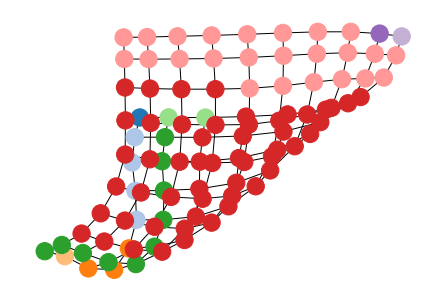

In [9]:
#this cell prints out the map with nodes colored by their district label
pos = nx.spring_layout(state)
districts = [state.nodes[node]['label'] for node in state.nodes()]
color_map = [plt.cm.tab20(i) for i in districts]
nx.draw(state, node_color=color_map,pos=pos)

In [10]:
def district_proportions(district):
    district_proportions = np.zeros(NUM_OF_DATA_FIELDS)
    for node in district.nodes:
        for i in range(NUM_OF_DATA_FIELDS):
            district_proportions[i] += district.nodes[node]['features'][i]
  #Now that we have total proportions, we can multiply those with state proportions and population proportions
#to get an overall proportion
  # print(district_proportions)
  # result = (1 / district_proportions[0]) * total_proportions
  # result = result * district_proportions
    return district_proportions

In [11]:
#Calculate an evaluation of how much the state has been gerrymandered per feature in the feature array
#(feature array is described above)
#Param: nx.Graph graph: the graph of the state, with districts apportioned by the "label" attribute
#Param: int[] total_proportions: should look like [1, % of state belonging to party 1, % of state belonging to party 2, etc.]
#these are the "target values" that a fair districting plan would try to approximate and that a gerrymander would stray from
#Returns: a list of values indicating the "approximation" proportions (the ones created by majorities in districts)
def majority_outcomes(graph, total_proportions):

    districts = get_district_subgraphs(graph)
    all_district_proportions = np.empty((len(districts),NUM_OF_DATA_FIELDS)) #one row per district, one column per attribute

  #start by calculating the values for the different attributes
    for i in range(len(districts)):
        all_district_proportions[i,:] = district_proportions(districts[i]) #one row per district
  
  #evaluate how many districts the binary attributes have a majority in - CURRENTLY UNUSED
    binary_majority_count = np.zeros(NUM_OF_DATA_FIELDS)
    for binary_item in BINARY_FIELDS:
        for proportion in all_district_proportions[:, binary_item]:
            if proportion > 0.5:
                binary_majority_count[binary_item] += 1
  
  #evaluate ternary attributes
    ternary_plurality_count = np.zeros(NUM_OF_DATA_FIELDS)
    for ternary_items in TERNARY_FIELDS: #fields are tuples
        for i in range(len(districts)):
      #make an array to store the proportions in the district
            to_compare = np.zeros(len(ternary_items)) 
      #get proportions for different items
            for j in range(len(ternary_items)):
                to_compare[j] = all_district_proportions[i, ternary_items[j]]
            plurality_index = np.argmax(to_compare)
            ternary_plurality_count[ternary_items[plurality_index]] += 1
    #print(all_district_proportions)
    #print(ternary_plurality_count)
    total_plurality_count = binary_majority_count + ternary_plurality_count
    total_plurality_count /= len(districts) #get proportion of districts in which the category wins
    return total_plurality_count #see how well the proportions of wins in the districts approximated the actual proportions!


In [12]:
print(proportions) #prints the actual proportions
majority_outcomes(state, proportions) #prints the proportion of elections won by each category
#If the state is perfectly evenly split (basically impossible), the very top row here should
#look very similar to the very bottom row

[1.         0.59341693 0.40658307 0.16248684 0.13437819 0.70313496]


array([0. , 0.7, 0.3, 0.1, 0. , 0.9])

In [26]:
""" A function to turn the data outputted by Cormac's gerrymandering algorithm back into a graph with new district labels

    Parameters
    ----------
    old_graph: networkx.Graph
        the graph that was fed into the gerrymandering algorithm
    
    assignments: tensor
        a p * k grid, where p is the number of precincts and k is the number of districts, with 0s everywhere except for 1s
        which indicate which district each precinct has been assigned to
    
    Returns
    -------
    new_graph: networkx.Graph
        The new graph with newly redistributed precincts
    
        """
def assignment_matrix_to_new_assignments(old_graph, assignments):
    assignments = assignments.numpy()
    new_graph = old_graph.copy()
    node_list = [node for node in old_graph.nodes()]
    for i in range(assignments.shape[0]):
        assignment = np.nonzero(assignments[i,:])
        new_graph.nodes()['label'] = assignment
    return new_graph    

In [28]:
""" A function, written by Jessica, attempting to gerrymander a grid graph.
THIS FUNCTION DOES NOT WORK. FOR WORKING GERRYMANDERING CODE, REFER TO CORMAC'S CODE IN 'Gerrymandering and detecting.ipynb'.

    Parameters
    ----------
    graph: networkx.Graph
        The graph to be gerrymandered
    
    total_proportions: numpy.ndarray(dtype='float')
        The overall state data
    
    target_idx: int
        The index to try to change the winning proportions for
        
    change: float
        The amount of change we are looking for in the target index
    
    Returns
    -------
    new_graph: networkx.Graph
        The gerrymandered graph (this does not actually work, it just gets caught in a loop!)
    
        """
def gerrymander(graph, total_proportions, target_idx, change=0.1):
    districts = get_district_subgraphs(graph)
    initial_result = majority_outcomes(graph, total_proportions)[target_idx]
    new_graph = graph.copy()
    difference = abs(initial_result - majority_outcomes(new_graph, total_proportions)[target_idx]) #should be 0 at first
    while difference < change: #note to self: consider checking old difference against new difference and undoing if needed
        d1 = random.choice(districts)
        while d1.number_of_nodes() < 2:
            d1 = random.choice(districts) #ensure we get a district with at least 2 nodes
        d1_node1 = get_random_node(d1.nodes)
        d1_node2 = get_random_node(d1.nodes) 
        while d1_node2 == d1_node1: #make sure we select two different nodes from district 1
            d1_node2 = get_random_node(d1.nodes)
        label1 = node_district(new_graph, d1_node1)
        label2 = None
        d2_node1 = None
        while d2_node1 == None:
            for neighbor in new_graph.adj[d1_node1]:
                if node_district(new_graph, neighbor) != label1: #if we have found the edge of the district
                    d2_node1 = neighbor
                    label2 = node_district(new_graph, neighbor)
                    break #for loop
            if d2_node1 != None:
                break #while loop
            else:
                new_d1_node1 = get_random_node(d1.nodes)
                while d1_node2 == new_d1_node1 or new_d1_node1 == d1_node1: #make sure we still have two different nodes
                    new_d1_node1 = get_random_node(d1.nodes)
                d1_node1 = new_d1_node1
        label3 = None #d2_node1 and d2_node2 might be in the same district but also might not
        d2_node2 = None
        while d2_node2 == None:
            for neighbor in new_graph.adj[d1_node2]:
                if node_district(new_graph, neighbor) != label1 and neighbor != d2_node1:
                    d2_node2 = neighbor
                    label3 = node_district(new_graph, neighbor)
                    break #for loop
            if d2_node2 != None:
                break #while loop
            else:
                new_d1_node2 = get_random_node(d1.nodes)
                while new_d1_node2 == d1_node1 or new_d1_node2 == d1_node2: #make sure we still have two different nodes
                    new_d1_node2 = get_random_node(d1.nodes)
                d1_node2 = new_d1_node2
                
        #print("4 nodes have been chosen!")
                
        #reassign labels and see if the graph assignments are still valid!
        new_graph.nodes[d1_node1]['label'] = label2 #remove a node from district 1
        new_graph.nodes[d2_node2]['label'] = label1 #add a node to district 1
        #we will leave the other two nodes alone, since the only reason we chose two pairs was to detect the district edges
        
        if valid_assignments(new_graph) == 0: #if we have produced a valid map
            difference = abs(initial_result - majority_outcomes(new_graph, total_proportions)[target_idx])
            #print("Valid assignments! New difference: ", difference)
        else: #revert the changes
            #print(valid_assignments(new_graph))
            #return new_graph
            new_graph.nodes[d1_node1]['label'] = label1
            new_graph.nodes[d2_node2]['label'] = label3
        
    return new_graph

#Helper method to return a random node from a node iterator
def get_random_node(node_iterator):
    node_list = []
    for node in node_iterator:
        node_list.append(node)
    if len(node_list) == 0:
        return 0 #if there is nothing in the iterator
    return random.choice(node_list)

#Helper method to return the district label for a precinct (node)
def node_district(graph, node):
    return graph.nodes[node]['label']

In [30]:
#Runs the attempted gerrymandering code. THIS WILL NOT WORK.
#new_state = gerrymander(state, proportions, 1)

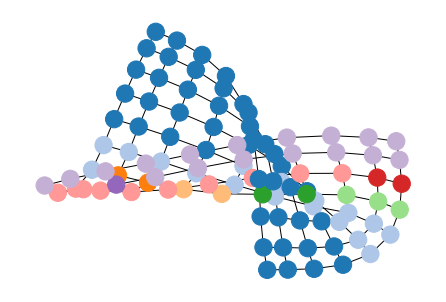

In [31]:
#draws the old state
districts = [state.nodes[node]['label'] for node in state.nodes()]
color_map = [plt.cm.tab20(i) for i in districts]
nx.draw(state, node_color=color_map,pos=pos)

In [32]:
#draws the new state generated above (again, this will not work)
# districts = [new_state.nodes[node]['label'] for node in new_state.nodes()]
# color_map = [plt.cm.tab20(i) for i in districts]
# nx.draw(new_state, node_color=color_map,pos=pos)